In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def display_image(title, image, cmap='gray'):
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Q1  Intensity Transformation

In [65]:
def intensity_transformation(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    lookup_table = np.zeros(256, dtype=np.float64)
    for i in range(0, 51):
        lookup_table[i] = i  # Maps 0-50
    m = (255-100)/100
    c = 255 - (m * 150)
    for i in range(51, 151):
        lookup_table[i] = m * i + c  # Maps 50-150 
    for i in range(151, 256):
        lookup_table[i] = i  # Maps 150-255

    # Apply the transformation using the lookup table
    transformed_image = cv2.LUT(image, lookup_table)
    display_image('Original Image', image)
    display_image('Transformed Image', transformed_image)

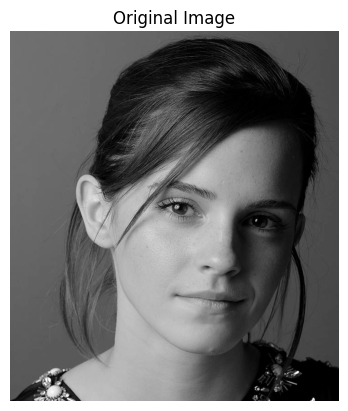

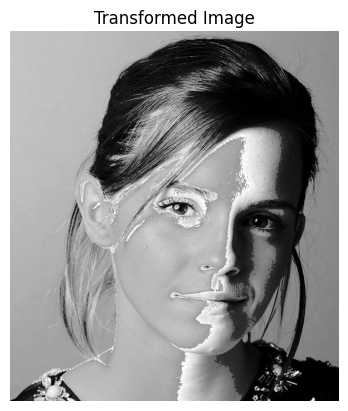

In [8]:
intensity_transformation('images/emma.jpg')

# Q2 Gray And White Matter

In [25]:
# Transform intensities for white matter accentuation
def transform_white_matter(input_intensity):
    if input_intensity < 128:
        return input_intensity * 0.5   # Reduce intensities below 128
    else:
        return 192 + (input_intensity - 128) * 0.5 # Amplify intensities above 128

# Transform intensities for gray matter accentuation
def transform_gray_matter(input_intensity):
    if input_intensity < 64:
        return input_intensity * 0.5   # Reduce intensities below 64
    elif input_intensity < 192:
        return 64 + (input_intensity - 64) * 1.5   # Amplify intensities between 64 and 192
    else:
        return 192 + (input_intensity - 192) * 0.5    # Reduce intensities above 192


def accentuate_white_gray_matter(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Error: Image not found.")
        return

    lut_white = np.array([transform_white_matter(i) for i in range(256)], dtype=np.uint8)
    lut_gray = np.array([transform_gray_matter(i) for i in range(256)], dtype=np.uint8)

    white_matter_image = cv2.LUT(image, lut_white)
    gray_matter_image = cv2.LUT(image, lut_gray)

    display_image('Original Image', image)
    display_image('White Matter Enhanced', white_matter_image)
    display_image('Gray Matter Enhanced', gray_matter_image)

    # Plot transformation curves
    x = np.arange(256)
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # White matter transformation plot
    axs[0].plot(x, lut_white, label='White Matter Transformation', color='blue')
    axs[0].set_title('White Matter Transformation Plot')
    axs[0].legend()

    # Gray matter transformation plot
    axs[1].plot(x, lut_gray, label='Gray Matter Transformation', color='green')
    axs[1].set_title('Gray Matter Transformation Plot')
    axs[1].legend()

    plt.show()

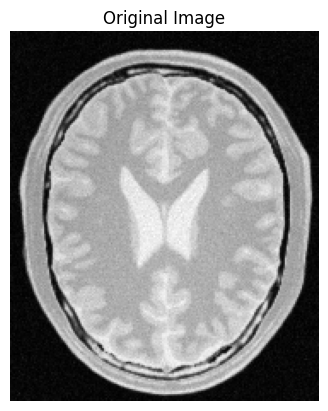

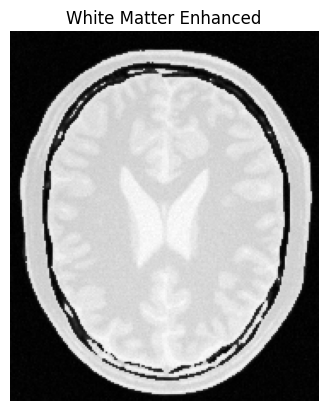

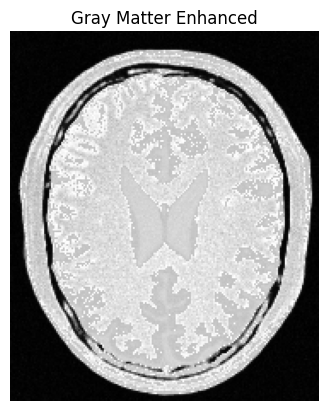

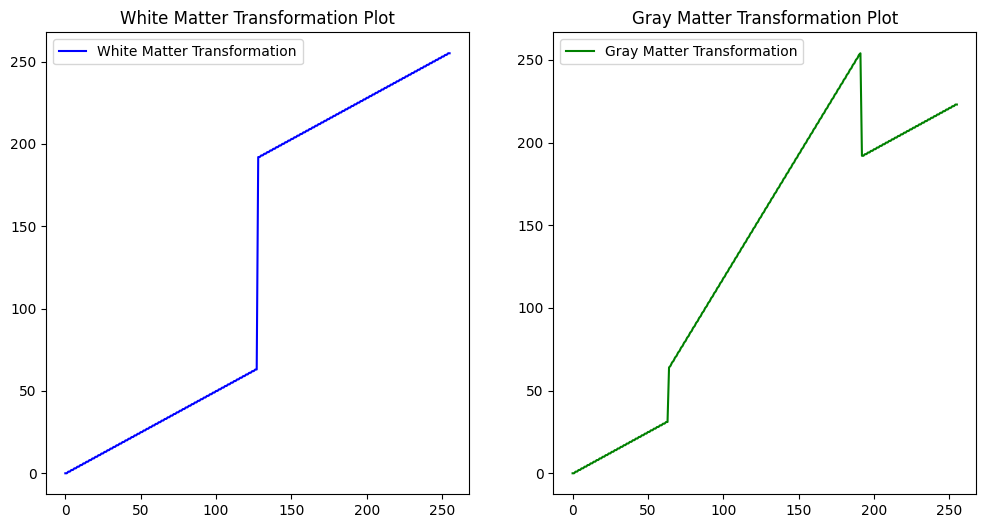

In [26]:
image_path = 'images/brain_proton_density_slice.png'
accentuate_white_gray_matter(image_path)

# Q3 Gamma Correction

In [27]:
def gamma_correction(image_path, gamma_value):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    assert img is not None, "Image could not be read, check the file path."
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2Lab)

    # Split the Lab image into L*, a*, and b* channels
    L, a, b = cv2.split(img_lab)

    # Create gamma correction lookup table for the given gamma value
    t = np.array([(p / 255) ** gamma_value * 255 for p in range(256)]).astype(np.uint8)

    # Apply the gamma correction using the lookup table
    L_gamma = cv2.LUT(L, t)
    img_gamma_lab = cv2.merge([L_gamma, a, b])
    img_gamma_rgb = cv2.cvtColor(img_gamma_lab, cv2.COLOR_Lab2RGB)

    # Display the original and gamma-corrected images using the helper function
    display_image('Original Image', img_rgb, cmap=None)
    display_image(f'Gamma Corrected Image (Gamma = {gamma_value})', img_gamma_rgb, cmap=None)

    # Plot the gamma correction curve
    plt.figure(figsize=(6, 4))
    plt.plot(t)
    plt.title(f"Gamma Correction Curve (Gamma = {gamma_value})")
    plt.xlabel("Input Intensity")
    plt.ylabel("Output Intensity")
    plt.show()

    # Plot histograms of L* channel (before and after gamma correction)
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.hist(L.ravel(), bins=256, color='gray', alpha=0.7, label='Original L')
    plt.title('Histogram of Original L Channel')
    plt.xlabel('L* value')
    plt.ylabel('Count')

    plt.subplot(1, 2, 2)
    plt.hist(L_gamma.ravel(), bins=256, color='gray', alpha=0.7, label='Corrected L')
    plt.title('Histogram of Gamma Corrected L Channel')
    plt.xlabel('L* value')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()


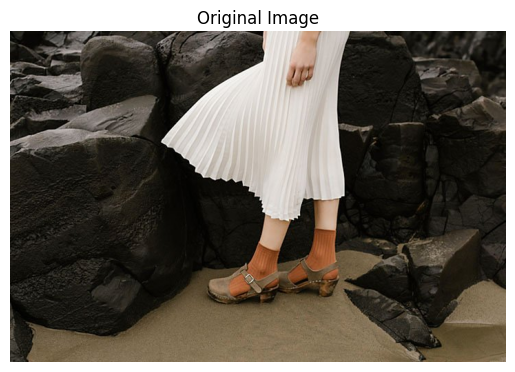

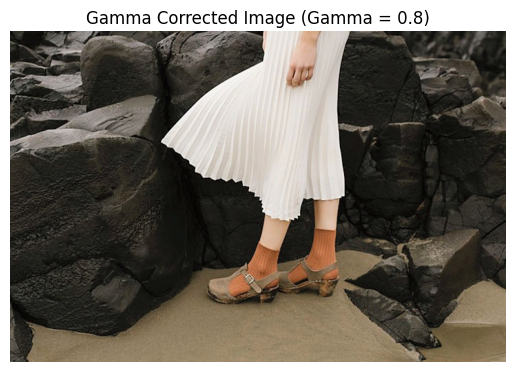

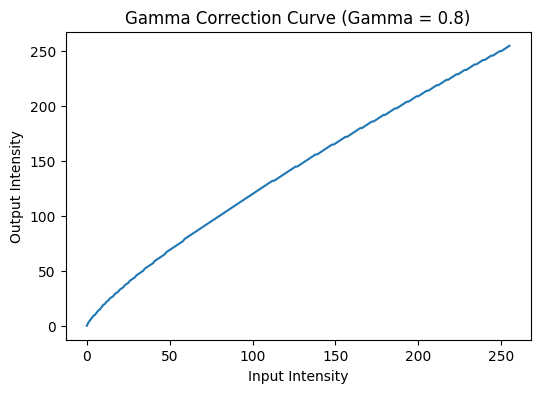

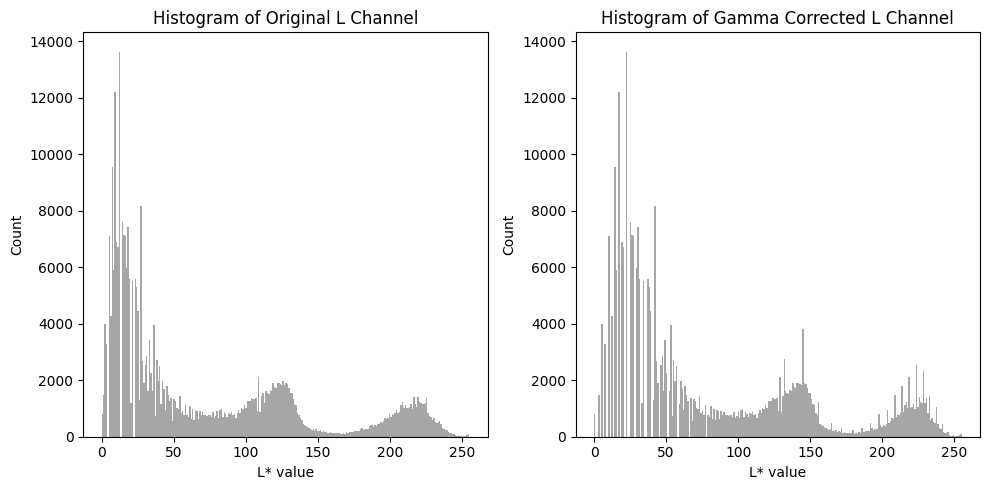

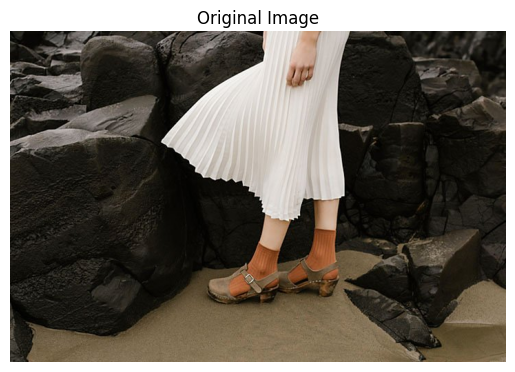

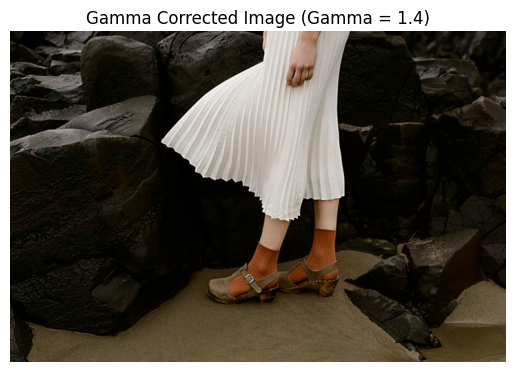

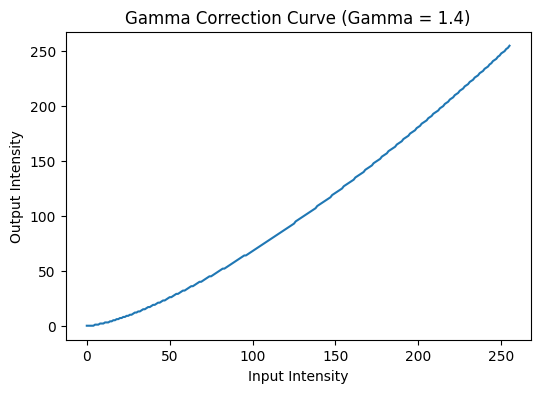

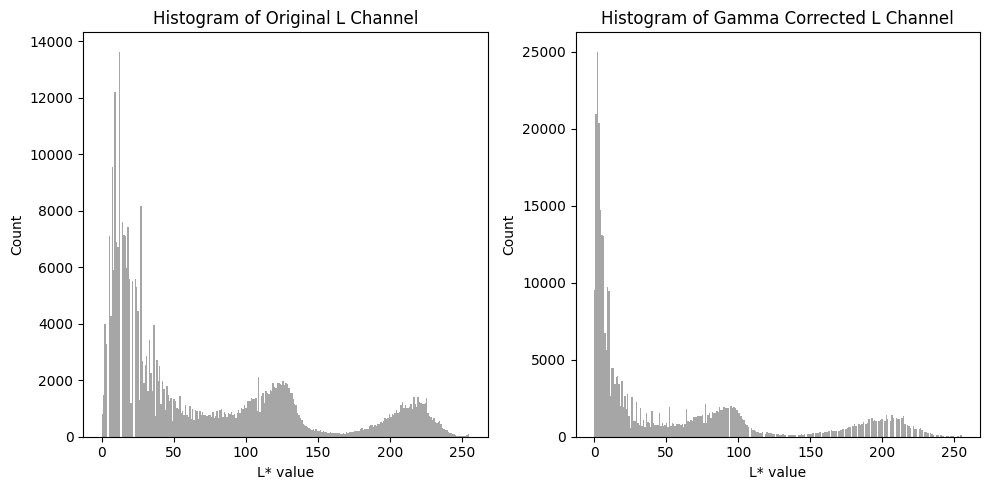

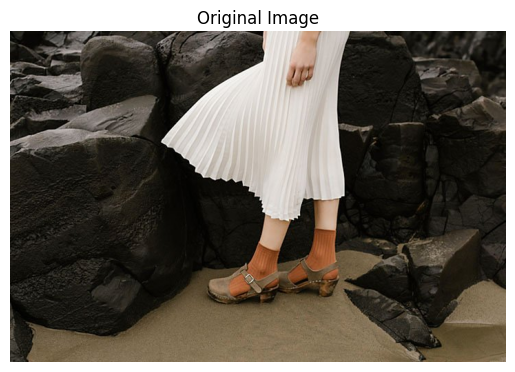

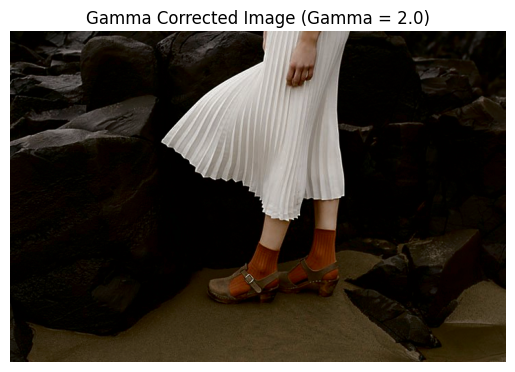

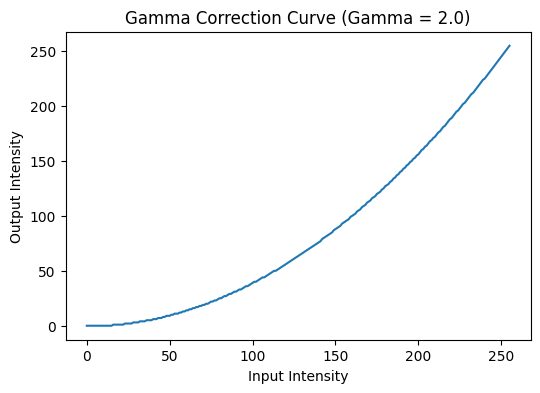

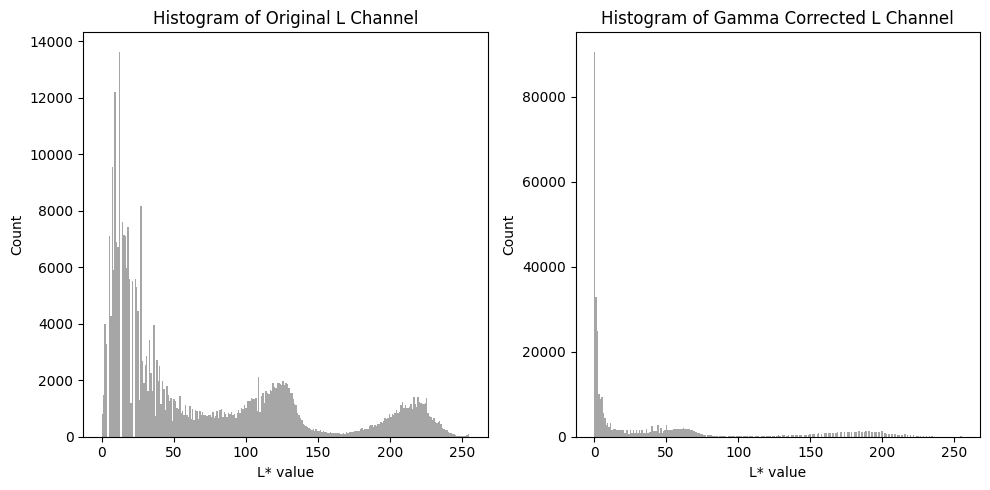

In [63]:
image_path = 'images/highlights_and_shadows.jpg'
gamma_correction(image_path, 0.8)
gamma_correction(image_path, 1.4)
gamma_correction(image_path, 2.0)


# Q4 Vibrance Enhancement

In [34]:
def vibrance_enhancement(image_path, a=0.7, sigma=70):
    img = cv2.imread(image_path)
    assert img is not None, "File could not be read, check with os.path.exists()"

    # Convert the image to HSV
    splited_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    H, S, V = cv2.split(splited_img)



    # Intensity transform function
    # Define the intensity transform function based on provided values of `a` and `sigma`
    t = np.array([p + a * 128 * np.exp(-(p - 128) ** 2 / (2 * sigma ** 2)) for p in range(256)])
    # Clip values to make sure they are in the range [0, 255]
    t_clipped = np.clip(t, 0, 255).astype(np.uint8)
    # Apply the intensity transform function to the saturation channel
    s_transformed = cv2.LUT(S, t_clipped)



    # Merge the H, transformed S, and V channels
    result = cv2.merge([H, s_transformed, V])
    result = cv2.cvtColor(result, cv2.COLOR_HSV2RGB)

    # Plot the transformation curve
    plt.plot(t_clipped)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Transformed Intensity")
    plt.title("Intensity Transform Function")
    plt.axis([0, 255, 0, 300])
    plt.grid()
    plt.show()

    # Display the original and vibrance-enhanced images using the helper function
    display_image("Original Image", cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cmap=None)
    display_image("Vibrance Enhanced Image", result, cmap=None)


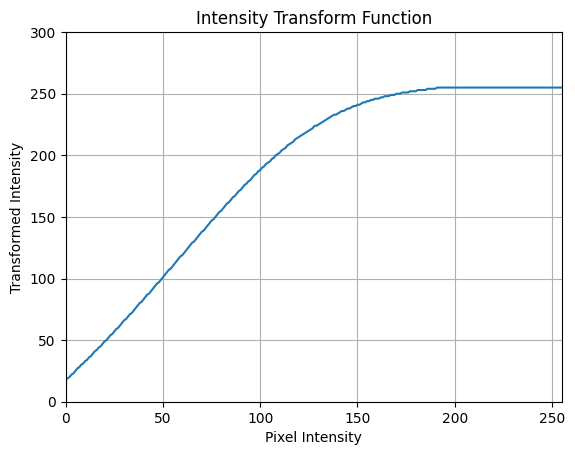

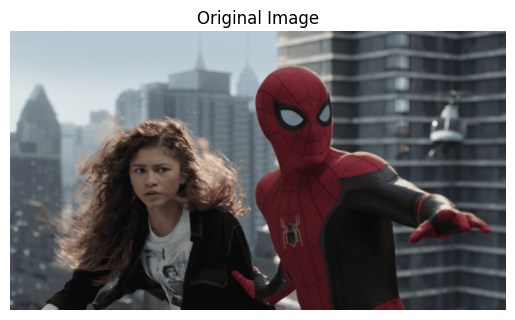

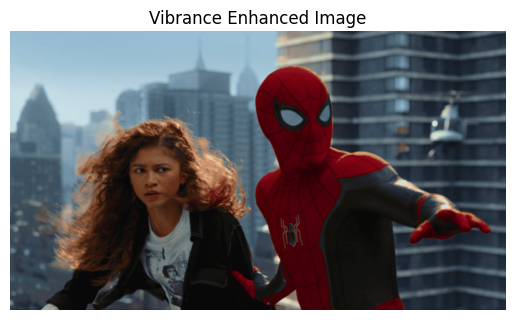

In [51]:
vibrance_enhancement('images/spider.png', a=0.75, sigma=70)

# Q5 Histogram Equalization

In [47]:
def calculate_histogram(image):
    histogram = np.zeros(256, dtype=int)
    for pixel in image.flatten():
        histogram[pixel] += 1
    return histogram


def histogram_equalization(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)    
    equalized_image = cv2.equalizeHist(image)
    
    original_hist = calculate_histogram(image)
    equalized_hist = calculate_histogram(equalized_image)

    # Display original and equalized images
    display_image('Original Image', image)
    display_image('Equalized Image', equalized_image)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(range(256), original_hist, color='black')
    plt.title('Original Histogram')
    plt.xlim([0, 255])

    plt.subplot(1, 2, 2)
    plt.bar(range(256), equalized_hist, color='black')
    plt.title('Equalized Histogram')
    plt.xlim([0, 255])
    plt.show()


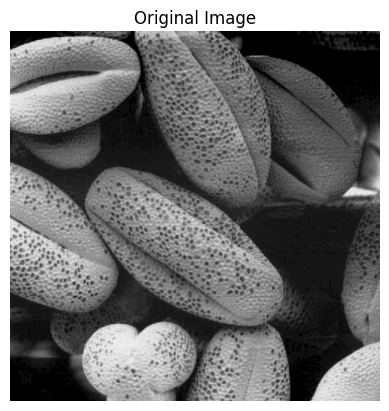

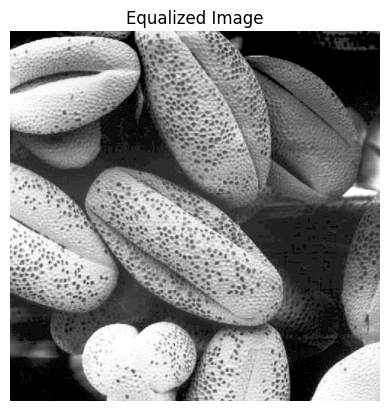

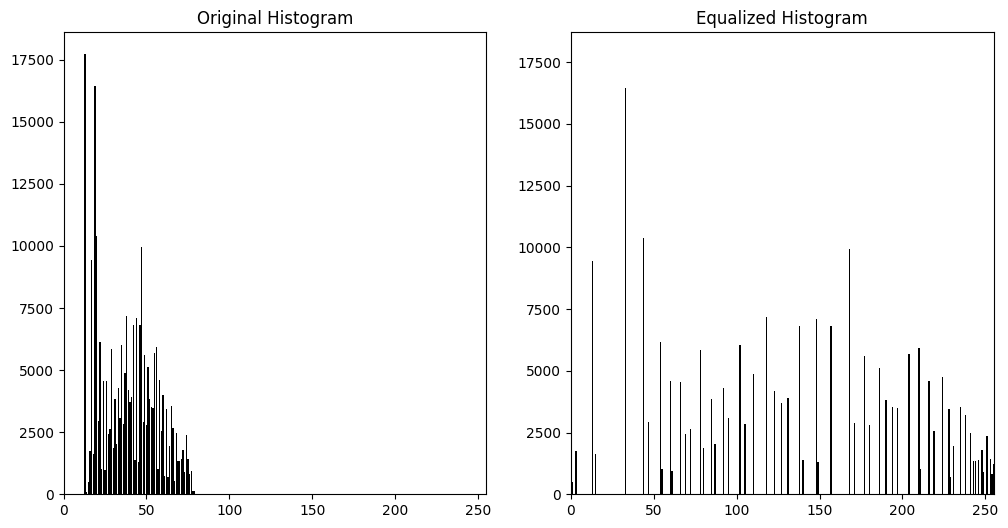

In [48]:
histogram_equalization('images/shells.tif')

# Q6 Histogram Equalization Foreground

In [54]:
def calculate_histogram(image):
    histogram = np.zeros(256, dtype=int)
    for pixel in image.flatten():
        histogram[pixel] += 1
    return histogram


def histogram_equalization_foreground(image_path):
    image = cv2.imread(image_path)
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Split the HSV image into hue, saturation, and value planes
    hue, saturation, value = cv2.split(image_hsv)
    
    # Display the hue, saturation, and value planes
    fig, ax = plt.subplots(1, 3, figsize=(15, 3))
    ax[0].imshow(hue, cmap='gray')
    ax[0].set_title('Hue')
    ax[0].axis('off')

    ax[1].imshow(saturation, cmap='gray')
    ax[1].set_title('Saturation')
    ax[1].axis('off')

    ax[2].imshow(value, cmap='gray')
    ax[2].set_title('Value')
    ax[2].axis('off')

    plt.show()

    # Thresholding to create a mask based on the value component
    _, mask = cv2.threshold(value, 75, 255, cv2.THRESH_BINARY)
    
    # Display the mask
    plt.figure(figsize=(6, 4))
    plt.imshow(mask, cmap='gray')
    plt.title('Foreground Mask')
    plt.axis('off')
    plt.show()

    # Apply bitwise_and to isolate the foreground in the value plane
    foreground_value = cv2.bitwise_and(value, value, mask=mask)
    
    # Calculate and display the histogram of the foreground value plane
    foreground_hist = calculate_histogram(foreground_value)
    
    plt.figure(figsize=(10, 4))
    plt.bar(range(256), foreground_hist, color='gray')
    plt.title('Histogram of Foreground')
    plt.xlim([0, 255])
    plt.show()

    # Calculate the cumulative sum of the histogram (CDF)
    cdf = np.cumsum(foreground_hist)
    
    # Display the CDF
    plt.figure(figsize=(10, 4))
    plt.plot(cdf, color='black')
    plt.title('Cumulative Distribution Function')
    plt.xlim([0, 256])
    plt.show()
    
    # Normalize the CDF to map the value plane
    cdf_normalized = (cdf * 255 / cdf.max()).astype(np.uint8)
    
    # Map the value plane using the normalized CDF
    equalized_value = cdf_normalized[foreground_value]
    
    # Combine the equalized foreground with the original background
    background_value = cv2.bitwise_and(value, value, mask=cv2.bitwise_not(mask))
    combined_value = cv2.bitwise_or(equalized_value, background_value)
    
    # Combine with original hue and saturation
    final_image_hsv = cv2.merge([hue, saturation, combined_value])
    
    # Convert the final HSV image back to BGR for display
    final_image = cv2.cvtColor(final_image_hsv, cv2.COLOR_HSV2BGR)
    
    # Display the original and final images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
    plt.title('With Histogram Equalized Foreground')
    plt.axis('off')
    plt.show()



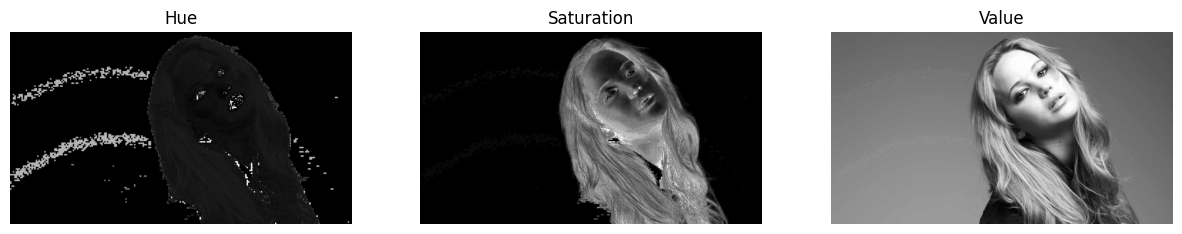

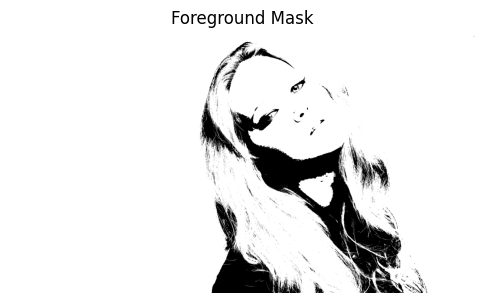

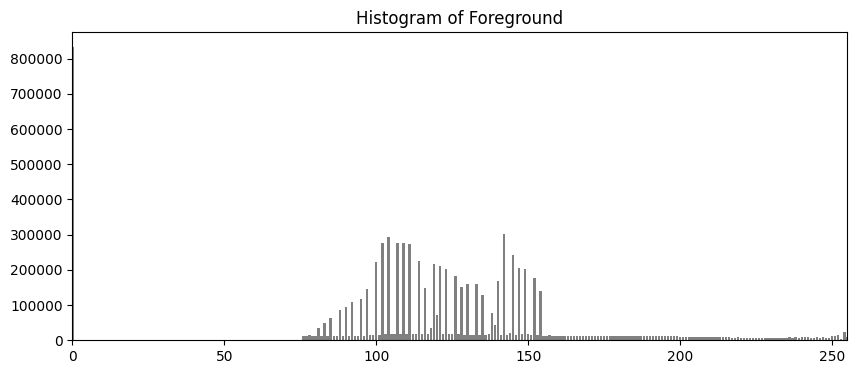

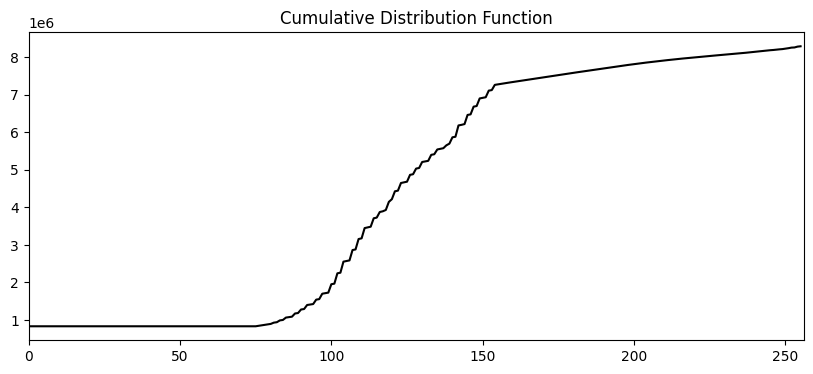

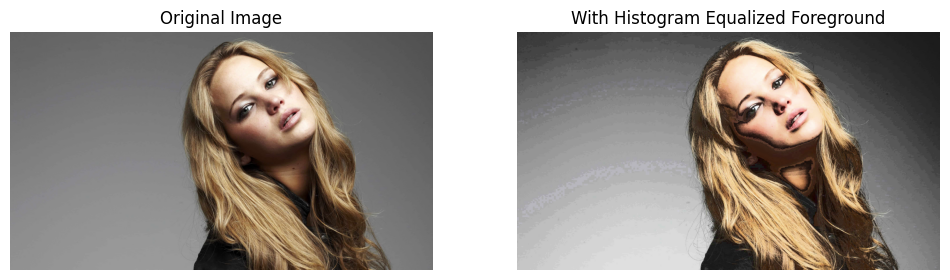

In [55]:
histogram_equalization_foreground('images/jeniffer.jpg')

# Q7 Sobel Filtering

In [60]:
def sobel_filtering(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Define Sobel kernels for x and y direction
    sobel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype="int")
    sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype="int")

    # Apply Sobel filters to the image
    sobel_filtered_x = cv2.filter2D(image, -1, sobel_x)
    sobel_filtered_y = cv2.filter2D(image, -1, sobel_y)

    # Calculate the gradient magnitude using the Sobel x and y results
    sobel_filtered = np.sqrt(sobel_filtered_x.astype(np.float32)**2 + sobel_filtered_y.astype(np.float32)**2)
    sobel_filtered = np.uint8(sobel_filtered)  # Convert back to uint8 type

    # Display the original and filtered images
    plt.figure(figsize=(12, 6))
    
    # Display Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Display Sobel X Image
    plt.subplot(1, 3, 2)
    plt.imshow(sobel_filtered_x, cmap='gray')
    plt.title('Sobel X Filtered Image')
    plt.axis('off')

    # Display Sobel Y Image
    plt.subplot(1, 3, 3)
    plt.imshow(sobel_filtered_y, cmap='gray')
    plt.title('Sobel Y Filtered Image')
    plt.axis('off')
    plt.show()

    # Display the combined Sobel filtered image (gradient magnitude)
    plt.figure(figsize=(6, 6))
    plt.imshow(sobel_filtered, cmap='gray')
    plt.title('Sobel Filtered Image (Gradient Magnitude)')
    plt.axis('off')
    plt.show()

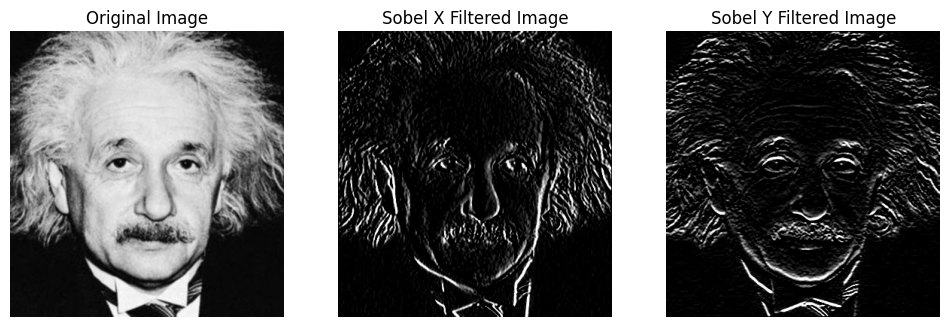

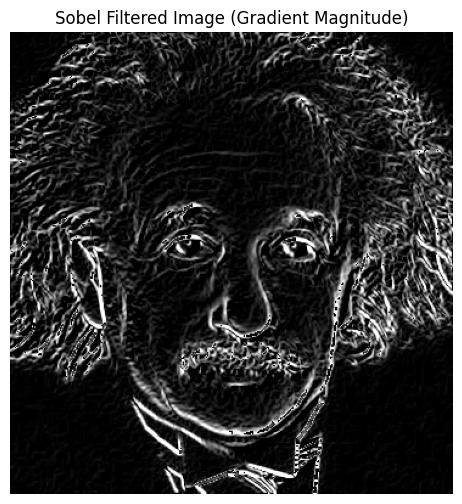

In [61]:
sobel_filtering('images/einstein.png')

# Q8

In [20]:

# 8. Image Zooming
def zoom_image(image_path, scale, method='bilinear'):
    image = cv2.imread(image_path)
    
    if method == 'bilinear':
        zoomed_image = cv2.resize(image, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
    else:
        zoomed_image = cv2.resize(image, None, fx=scale, fy=scale, interpolation=cv2.INTER_NEAREST)
    
    display_image('Original Image', image, cmap=None)
    display_image(f'Zoomed Image (Method: {method})', zoomed_image, cmap=None)

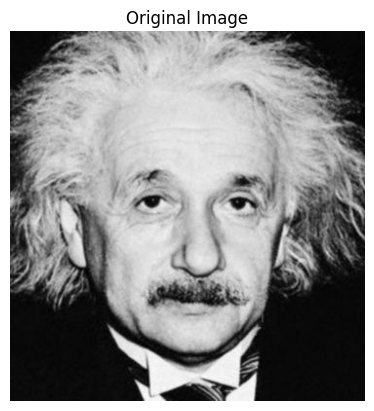

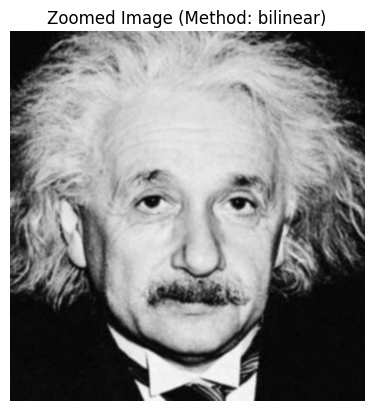

In [22]:
zoom_image('images/einstein.png', scale=2, method='bilinear')

# Q9

In [23]:

# 9. Image Segmentation with GrabCut
def grabcut_segmentation(image_path):
    image = cv2.imread(image_path)
    mask = np.zeros(image.shape[:2], np.uint8)
    
    # Define initial bounding box for segmentation
    rect = (50, 50, image.shape[1] - 50, image.shape[0] - 50)
    
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)
    
    # Apply GrabCut
    cv2.grabCut(image, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)
    
    # Extract foreground and background
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    foreground = image * mask2[:, :, np.newaxis]
    background = image * (1 - mask2[:, :, np.newaxis])
    
    display_image('Original Image', image, cmap=None)
    display_image('Foreground', foreground, cmap=None)
    display_image('Background', background, cmap=None)

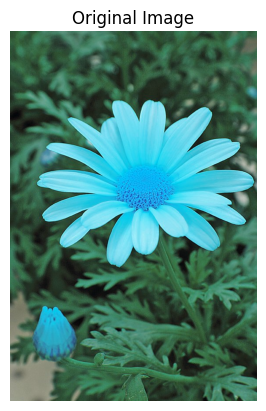

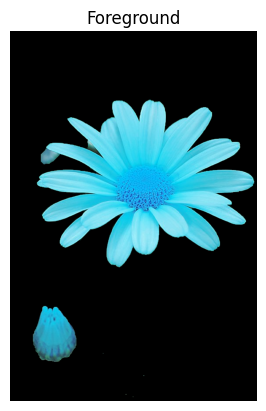

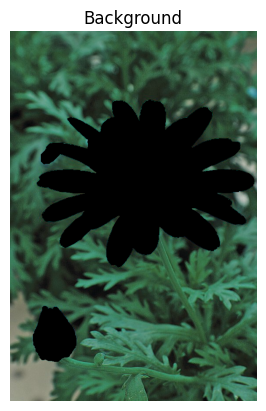

In [24]:
grabcut_segmentation('images/daisy.jpg')